In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
import pandas as pd 

In [2]:
my_words = list(open("test-my-word-2-vec.txt",encoding="UTF-8").read())
my_words = pd.Series(my_words)

In [3]:
count = my_words.value_counts().sort_values(ascending=False)
chars  = count.index.sort_values()
char_ids = pd.DataFrame(list(zip(chars,list(range(len(chars))))),columns=["char","id"])

dictionary = char_ids.set_index("char")["id"].to_dict()
dictionary_reverse = char_ids.set_index("id")["char"].to_dict()

In [4]:
data = my_words.map(dictionary)
skip_window = 1
len(data)

result_feature = []
result_lable = []
for i in range(0+skip_window,len(data)-skip_window):
    feature = data[i]
    j = skip_window
    for lable in data[i-j:i]:
        result_feature.append(feature)
        result_lable.append(lable)
    for lable in data[i+1:i+j+1]:
        result_feature.append(feature)
        result_lable.append(lable)

In [5]:
batch_size = 32
embedding_size = 32
num_sampled = 64
vocabulary_size = len(chars)
vocabulary_size

valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))

In [6]:
train_feature_dataset =  tf.contrib.data.Dataset.from_tensor_slices(result_feature)
train_lable_dataset = tf.contrib.data.Dataset.from_tensor_slices(result_lable)

In [7]:
feature_iterator = train_feature_dataset.repeat().batch(batch_size).make_initializable_iterator()
label_iterator = train_lable_dataset.repeat().batch(batch_size).make_initializable_iterator()

In [8]:
train_features = tf.placeholder(tf.int32, shape=[batch_size],name="train_featuers")
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1],name="train_labels")
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))

softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],stddev=1.0 / math.sqrt(embedding_size)))
softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
embed = tf.nn.embedding_lookup(embeddings, train_features)
loss = tf.reduce_mean(
  tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                             labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [9]:
with tf.Session() as session : 
    tf.global_variables_initializer().run()
    session.run(feature_iterator.initializer)
    session.run(label_iterator.initializer)
    batch_data = session.run(feature_iterator.get_next())
    batch_labels = session.run(label_iterator.get_next())
    feed_dict = {train_features : batch_data, train_labels : batch_labels.reshape([batch_size,1])}
    session.run([train_labels], feed_dict=feed_dict)


In [11]:
num_steps = 1001
with tf.Session() as session : 
    tf.global_variables_initializer().run()
    session.run(feature_iterator.initializer)
    session.run(label_iterator.initializer)
    average_loss=0
    for step in range(num_steps):
        batch_data = session.run(feature_iterator.get_next())
        batch_labels = session.run(label_iterator.get_next())
        feed_dict = {train_features : batch_data, train_labels : batch_labels.reshape([batch_size,1])}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 20 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = dictionary_reverse[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = dictionary_reverse[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Average loss at step 0: 3.428112
Nearest to 个: 虑, 伦, 溅, 她, 钻, 章, 弹, 即,
Nearest to @: 切, 挤, 设, 合, 请, 这, 梯, t,
Nearest to 一: 无, D, 如, 请, 亚, V, ﻿, 列,
Nearest to 5: 请, 源, 设, 2, 晨, 长, 白, 压,
Nearest to R: 疗, 压, 虚, 卫, 电, 对, 底, 吃,
Nearest to 于: 至, 摄, 易, 十, 囚, 探, 浇, 事,
Nearest to 了: 通, 同, 争, 始, 媒, 出, 洒, 有,
Nearest to o: 果, 需, 媒, 持, 买, 载, 郊, 怒,
Nearest to N: 学, 季, 罗, 讲, 少, 半, 激, 无,
Nearest to 令: 住, 就, 许, 拼, 阿, 裂, 非, 挽,
Nearest to 也: 手, 么, 或, 际, 帮, 等, 器, 压,
Nearest to p: 次, 构, 中, 活, 刀, 望, 房, 肺,
Nearest to 《: 其, 武, 眼, 吸, 病, 至, 、, 诸,
Nearest to  : 几, 式, 会, 质, 写, 定, 观, 理,
Nearest to 他: 作, 年, 脱, 帮, 然, 器, 广, 负,
Nearest to C: 杏, 表, 路, 调, T, 戏, 者, 目,
Average loss at step 20: 0.038062
Average loss at step 40: 0.036128
Average loss at step 60: 0.033968
Average loss at step 80: 0.031040
Average loss at step 100: 0.031470
Average loss at step 120: 0.031001
Average loss at step 140: 0.030885
Average loss at step 160: 0.032255
Average loss at step 180: 0.034147
Average loss at step 200: 0.025646
Average loss 

In [12]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

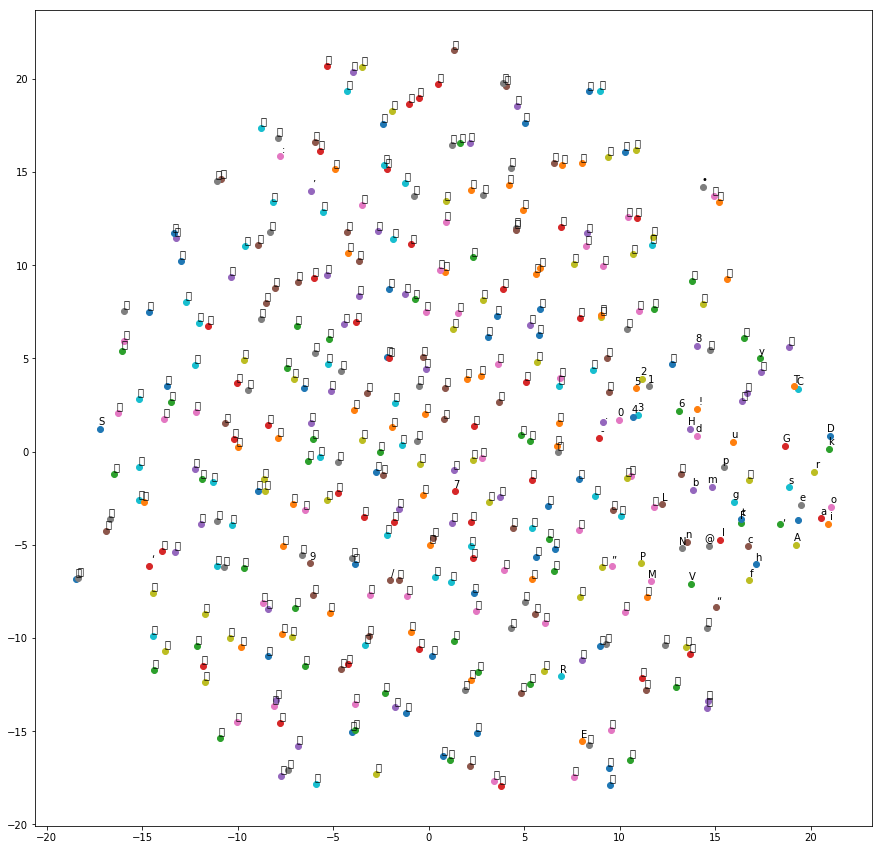

In [13]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [dictionary_reverse[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

In [ ]:
# data[0:2]
# data[0:1]
# data[1:2]
# pd.DataFrame({
#     "feature": result_feature,
#     "lable" : result_lable
# })